# Introduction

In this notebook, we are putting Deep Learning models in to practices.

With the dataset of ***360 Fruit***, which includes around a hundred of fruit families with hundreds images for each, we are using:
* A ***handmade-by-me CNN***.
* A state-of-the-OLD-art: ***LeNet5***
* Transform learning with the giant ***ResNet-152***
* Transform learning with the tiny ***SqueezeNet***

Then, each model practicing following by a classification report and a tunning.

At last, we will discuss which one is the best, why, how, and other questions.


***Dataset properties***

* Total number of images: 90483.
* Training set size: 67692 images (one fruit or vegetable per image).
* Test set size: 22688 images (one fruit or vegetable per image).
* Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)
* Number of classes: ***131*** (fruits and vegetables).
* Image size: ***100x100*** pixels.

# Import Packages

In [1]:
# Bases
import keras as k
import tensorflow as tf
from keras import backend as K

## data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LayerNormalization, GlobalAveragePooling2D

## plotting
import os
import numpy as np
import matplotlib.pyplot as plt

## callbacks
from keras.callbacks import TensorBoard
import time

from keras.applications import ResNet152
from keras import Input, Model

import sklearn
from sklearn.metrics import  classification_report, roc_curve

Using TensorFlow backend.


## Environment Configuration for GPU

As the VRAM of GPU is 3GB, not enough to work with cudnn, we will do some tricks force GPU to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

memory_limit=1024
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         #tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16646125887686761258
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13698274492892387694
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7561320273033178355
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10514659923001323414
physical_device_desc: "device: XLA_GPU device"
]


# Data Preparing

The dataset has the following directory ***structure***:

<pre>
<b>Fruit Images Dataset</b>
|__ <b>train</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
|__ <b>test</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
</pre>

***How to prepare data***

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`, which can:
* Read images and preprocess them into proper tensors. 
* Set up generators that convert these images into batches of tensors — helpful when training the network.

In [6]:
# Generator
train_generator = ImageDataGenerator(rescale=1/255)
val_generator = ImageDataGenerator(rescale=1/255)

In [7]:
# Variable for pre-processing and training
batch_size = 128
epochs = 15

IMG_HEIGHT = 100
IMG_WIDTH = 100

num_classes = 131

where_train = '/home/maihai/GitHub/Fruit-Images-Dataset/train'
where_test  = '/home/maihai/GitHub/Fruit-Images-Dataset/test'

After defining the generators, the `flow_from_directory` method will:
* Load images from the disk,
* Applies rescaling,
* Applies resizes images into the required dimensions.

In [8]:
train_data_gen = train_generator.flow_from_directory(directory=where_train, 
                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         class_mode='sparse',
                                         shuffle=True,
                                         batch_size=batch_size)

Found 67692 images belonging to 131 classes.


In [9]:
val_data_gen = val_generator.flow_from_directory(directory=where_test,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode='sparse',
                                        shuffle=True,
                                        batch_size=batch_size)

Found 22688 images belonging to 131 classes.


## Visualize Training Images

To visualize the training images, we will:
* Extracting a batch from the training generator — which is 32 images
* Then plot five of them with `matplotlib`.

In [10]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset, which is in form of `(x_train, y_train)`. We discard the labels to only visualize the training images.

In [11]:
# This function: plots images in the form of a 1 row x 5 cols grid.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

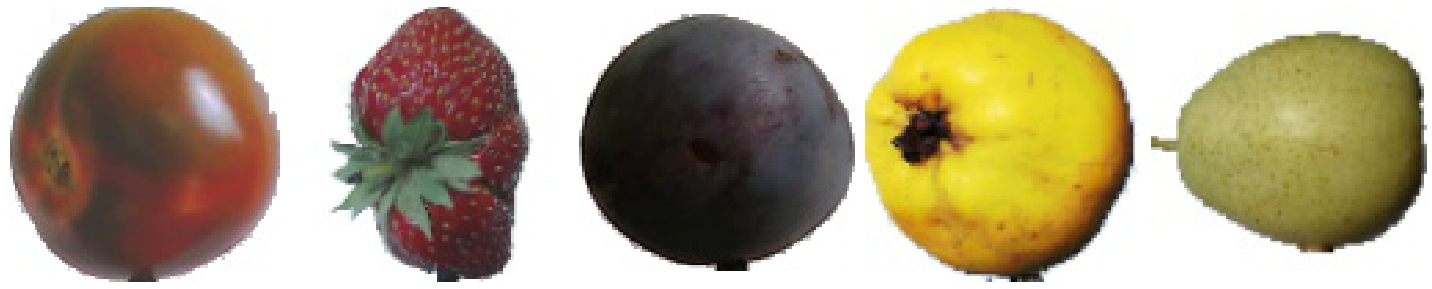

In [12]:
plotImages(sample_training_images[:5])

# My Handmade Model

## Compile and train the baseline model

In [13]:
model_baseline = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(131, activation = 'softmax')
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [14]:
model_baseline.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy', 'AUC'])

In [16]:
# Set up TensorBoard
NAME = 'Handmade_model_baseline_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [17]:
%%time
# Train model_baseline
history = model_baseline.fit(train_data_gen,
                             steps_per_epoch=67692 // batch_size,
                             epochs=epochs,
                             validation_data=val_data_gen,
                             validation_steps=22688 // batch_size,
                             callbacks=[tensorboard])

Epoch 1/15
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
528/528 [==============================] - 48s 90ms/step - loss: 0.4360 - categorical_accuracy: 0.8961 - auc: 0.9948 - val_loss: 0.2657 - val_categorical_accuracy: 0.9438 - val_auc: 0.9942
Epoch 2/15
528/528 [==============================] - 33s 62ms/step - loss: 0.0241 - categorical_accuracy: 0.9937 - auc: 0.9997 - val_loss: 0.2321 - val_categorical_accuracy: 0.9549 - val_auc: 0.9933
Epoch 3/15
528/528 [==============================] - 33s 62ms/step - loss: 0.0149 - categorical_accuracy: 0.9957 - auc: 0.9998 - val_loss: 0.3438 - val_categorical_accuracy: 0.9228 - val_auc: 0.9900
Epoch 4/15
528/528 [==============================] - 33s 63ms/step - loss: 0.0150 - categorical_accuracy: 0.9962 - auc: 0.9997 - val_loss: 0.2020 - val_categorical_accuracy: 0.9586 - val_auc: 0.9943
Epoch 5/15
528/528 [==============================] - 35s 66ms/step - loss: 0.0226 - categorical_accuracy: 0.9942 - auc

In [31]:
where_to_save = 'Handmade_model_baseline_weights'
model_baseline.save_weights(filepath=where_to_save,
                            overwrite=False)

In [32]:
# Clear VRAM
K.clear_session()

## The results

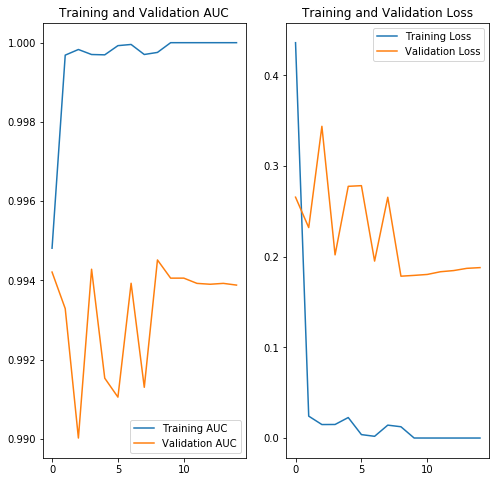

In [33]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

We will only use 1500 out of the entire test set, as time cost for all of them are so high.

In [15]:
model_baseline.load_weights('Handmade_model_baseline_weights')

### Inspect y_pred

In [31]:
y_pred = model_baseline.predict(val_data_gen,
                                batch_size=batch_size,
                                    steps=22688/batch_size,
                                    verbose=1)

178/177 [==============================] - 13s 73ms/step


In [20]:
y_pred.shape

(22688, 131)

In [22]:
y_pred[:1]

array([[8.18405008e-24, 4.93367618e-30, 9.99999881e-01, 5.29086037e-08,
        6.95703974e-08, 1.26393757e-11, 7.95991819e-19, 7.50619877e-20,
        9.50449648e-17, 2.87686987e-20, 1.47847915e-30, 1.45243906e-09,
        3.71823579e-19, 1.42317104e-27, 1.43944790e-26, 2.99872787e-34,
        5.97367139e-21, 7.15196825e-12, 4.81762310e-30, 9.53699092e-27,
        6.47889333e-29, 1.54642462e-11, 5.69456320e-14, 3.75483845e-12,
        1.32729738e-13, 9.75627570e-25, 7.76334349e-27, 4.72981612e-30,
        2.66609212e-22, 2.77984846e-29, 2.15282836e-34, 2.06809836e-18,
        1.08093563e-23, 2.37529805e-24, 3.78127186e-27, 3.65993203e-20,
        6.34928012e-25, 1.62535292e-23, 1.81649741e-19, 1.36320312e-30,
        2.26545605e-29, 5.31777709e-36, 2.84359027e-21, 8.09412938e-18,
        6.58291014e-35, 1.24565152e-28, 1.84815479e-25, 2.51694269e-17,
        4.85920737e-15, 2.58292316e-21, 4.69913233e-16, 1.95465422e-08,
        2.08282191e-09, 9.14540335e-33, 0.00000000e+00, 5.351497

In [23]:
np.max(y_pred[:1])

0.9999999

In [26]:
np.argmax(y_pred[:1])

2

In [35]:
y_pred_argmax = np.argmax(y_pred, axis=1)
print(y_pred_argmax)

[ 60  58  86 ...  77 102  58]


### Inspect y_true

In [36]:
type(val_data_gen)

keras_preprocessing.image.directory_iterator.DirectoryIterator

In [37]:
dir(val_data_gen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'labels',
 'lock',
 'n',
 'next',
 'num_classes',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'samples',
 'save_format',
 'save_prefix',
 'save_to_dir',
 'seed',
 'set_processing_attrs',
 'shuffle',
 'sp

In [43]:
val_data_gen.classes

array([  0,   0,   0, ..., 130, 130, 130], dtype=int32)

In [28]:
y_true = val_data_gen.classes
print(y_true)

[  0   0   0 ... 130 130 130]


In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       148
           2       0.01      0.01      0.01       160
           3       0.01      0.02      0.02       164
           4       0.01      0.01      0.01       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.01      0.01      0.01       164
           8       0.00      0.00      0.00       164
           9       0.01      0.01      0.01       144
          10       0.01      0.01      0.01       166
          11       0.00      0.00      0.00       164
          12       0.01      0.01      0.01       219
          13       0.02      0.02      0.02       164
          14       0.00      0.00      0.00       143
          15       0.02      0.02      0.02       166
          16       0.00      0.00      0.00       166
          17       0.01    

In [30]:
path = '/home/maihai/GitHub/Fruit-Images-Dataset/test/Apple Braeburn/3_100.jpg'

pic = tf.keras.preprocessing.image.load_img(
    path, 
    grayscale=False, 
    color_mode='rgb', 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest')

In [31]:
y_pred = model_baseline.predict(pic)
y_pred = np.argmax(y_pred, axis=-1)

ValueError: Failed to find data adapter that can handle input: <class 'PIL.JpegImagePlugin.JpegImageFile'>, <class 'NoneType'>

# Approachs for Better Predictions

Trinh bay ly do: Data aug, Dropout

Even out simplest model gets a quiet good result, but I want to test if is improved by several common techniques, which are:
* Data augmentation
* Dropout.

## Data Augmentation

In [13]:
image_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               rotation_range=45)

In [14]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=where_train,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 67692 images belonging to 131 classes.


In [15]:
sample_training_images, _ = next(train_data_gen)

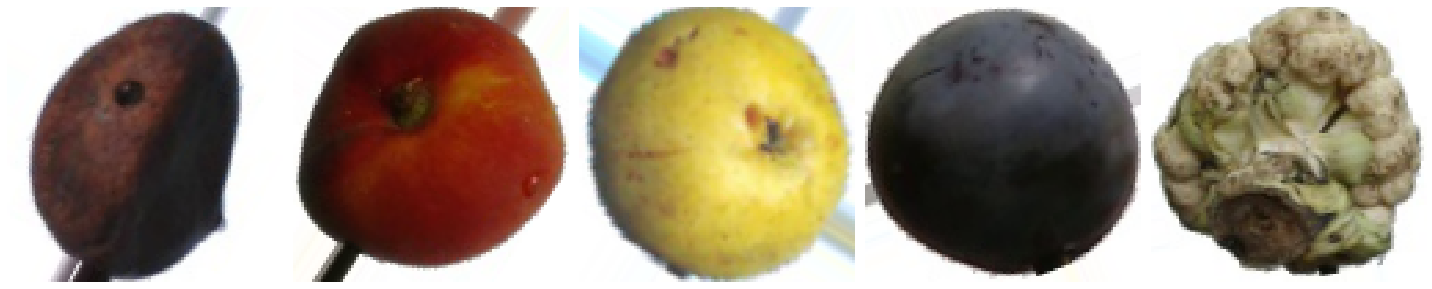

In [16]:
plotImages(sample_training_images[:5])

We only apply image augmentation on the training data, not on the test dataset.  
Because the test set should be remained as its origin.

## Dropout

***What is Dropout***

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## The new handmade model with Dropout

In [17]:
model_with_dropout = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(131, activation = 'softmax')
])

model_with_dropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0

In [18]:
model_with_dropout.compile(optimizer='adam',
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['categorical_accuracy', 'AUC'])

## Train the new handmade modelclassification_report

In [40]:
NAME = 'Handmade_model_Augmentation_Dropout_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [41]:
%%time
history = model_with_dropout.fit(train_data_gen,
                                 steps_per_epoch=67692 // batch_size,
                                 epochs=epochs,
                                 validation_data=val_data_gen,
                                 validation_steps=22688 // batch_size,
                                 callbacks=[tensorboard])

Epoch 1/15
528/528 [==============================] - 132s 250ms/step - loss: 0.8467 - categorical_accuracy: 0.7749 - auc: 0.9899 - val_loss: 0.3945 - val_categorical_accuracy: 0.8863 - val_auc: 0.9930
Epoch 2/15
528/528 [==============================] - 130s 247ms/step - loss: 0.1065 - categorical_accuracy: 0.9651 - auc: 0.9992 - val_loss: 0.2698 - val_categorical_accuracy: 0.9235 - val_auc: 0.9954
Epoch 3/15
528/528 [==============================] - 130s 246ms/step - loss: 0.0626 - categorical_accuracy: 0.9804 - auc: 0.9994 - val_loss: 0.2999 - val_categorical_accuracy: 0.9250 - val_auc: 0.9939
Epoch 4/15
528/528 [==============================] - 130s 246ms/step - loss: 0.0460 - categorical_accuracy: 0.9852 - auc: 0.9996 - val_loss: 0.2574 - val_categorical_accuracy: 0.9497 - val_auc: 0.9932
Epoch 5/15
528/528 [==============================] - 131s 248ms/step - loss: 0.0453 - categorical_accuracy: 0.9857 - auc: 0.9995 - val_loss: 0.1952 - val_categorical_accuracy: 0.9615 - val_au

In [42]:
where_to_save = 'Handmade_model_Augmentation_Dropout_weights'
model_with_dropout.save_weights(filepath=where_to_save,
                                overwrite=False)

In [51]:
# Clear VRAM
K.clear_session()

## Results

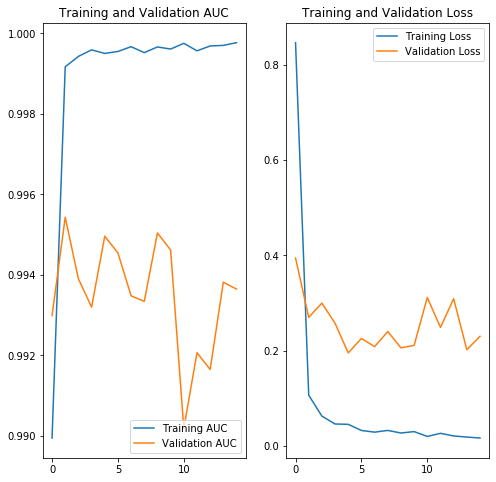

In [46]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

We will only use 1500 out of the entire test set, as time cost for all of them are so high.

In [19]:
model_with_dropout.load_weights('Handmade_model_Augmentation_Dropout_weights')

In [33]:
%%time
y_pred = model_with_dropout.predict(val_data_gen,
                                    steps=22688/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred, axis=-1)

178/177 [==============================] - 8s 45ms/step
CPU times: user 10.4 s, sys: 457 ms, total: 10.9 s
Wall time: 8.1 s


In [40]:
y_true = val_data_gen.classes

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.02      0.01       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.01      0.01      0.01       164
           4       0.00      0.01      0.00       161
           5       0.01      0.01      0.01       164
           6       0.01      0.01      0.01       152
           7       0.00      0.01      0.01       164
           8       0.00      0.00      0.00       164
           9       0.01      0.01      0.01       144
          10       0.03      0.03      0.03       166
          11       0.00      0.00      0.00       164
          12       0.02      0.02      0.02       219
          13       0.01      0.01      0.01       164
          14       0.01      0.01      0.01       143
          15       0.01      0.01      0.01       166
          16       0.00      0.00      0.00       166
          17       0.02    

# Evaluate

In [39]:
# Gini score to evaluate performances of models gini_score= 2*auc -1
def gini_score(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini_coef = 2 * roc_auc - 1
    print('Gini score: %5.4f' %(gini_coef))
    
    return gini_coef

In [41]:
gini_score(y_true, y_pred)

ValueError: multiclass format is not supported

# Analysis and Compare Models